# Что это за pet-проект?

Этот pet-проект я выполнял изначально как финальный проект по учебной дисциплине "Программирование на Python" (2025 год). Я дополнил и переработал его для портфолио.

Проект демонстрирует мои следующие навыки и знания:

*   Умение проводить разведочный анализ данных (EDA), в т.ч. оценивать качество данных, обрабатывать и трансформировать данные, а также их визуализировать.
*   Умение формулировать исследовательские гипотезы и переводить их на язык статистических гипотез.
* Знание допущений для применения разных статистических тестов, умение проверять допущения, проводить статистические тесты и правильно их интерпретировать*.
* Умение извлекать бизнес-инсайты даже на ограниченных, неполных данных.
* Умение составлять отчет по проделанной работе.

\* примечание: в работе со статистическими тестами я исхожу из допущения, что используемый датасет содержит случайные выборки.


# Постановка цели и описание логики представления работы

Предположим, что нам поступила срочная ad-hoc задача: сын одного миллиардера на деньги отца захотел войти в авиабизнес и хочет уже сегодня за семейным ужином представить идею отцу. Сын выступает нашим заказчиком. Он пришел с идеей, что ему нужно найти такую целевую аудиторию пассажиров, которая чем-то неудовлетворена в своих перелетах. Заказчик хочет, чтобы мы нашли ему какую-то нишу, в которой есть в чем-то слабые авиакомпании-конкуренты, которых он мог бы в чем-то опередить. Конкретных идей у заказчика нет, но у него есть набор данных с отзывами, который он просит использовать для анализа так, как нам угодно. Ему главное, чтобы мы определили нишу и дали рекомендации, что ему делать дальше.

Работа выстроена по следующему плану. В самом начале мы занимаеся базовыми техническими приготовлениями, включая базовую проверку и обработку основной используемой нами таблицы "Airline" (отзывы на полеты на конкретных авиалиниях). Затем мы начинаем поэтапно подбирать целевую аудиторию нашему заказчику, чему посвящены разделы:

* "Вопрос 1": Мы смотрим, пассажиры из какого географического региона наименее удовлетворены своими перелетами (ответ: из георегиона "Америки").

* "Стат. тест 1": Мы убеждаемся, что обнаруженная в ответе на первый вопрос разница является неслучайной с точки зрения статистики (ответ: да, она неслучайная).

* "Вопрос 2": Чтобы сузить целевую аудиторию, мы смотрим, пассажиры какого класса полета из георегиона "Америки" наименее удовлетворены своими перелетами (ответ: пассажиры эконом-класса, включая эконом-премиум).

* "Стат. тест 2". Мы убеждаемся, что обнаруженная в ответе на второй вопрос разница является неслучайной с точки зрения статистики (ответ: да, она неслучайная).

После определения более-менее узкой целевой аудитории (пассажиры эконом-класса георегиона "Америки") в разделе "Вопрос 3" мы определяем 10 потенциальных конкурентов нашему заказчику, а затем смотрим, у кого из них наихудшие кресла по оценкам целевой аудитории.

Отчет завершается разделом с подведением итогов и практическими рекомендациями для заказчика.

# Базовая подготовка

## Подгрузим и импортируем нужные библиотеки

Библиотека "scikit_posthocs", с помощью которой в одном из разделов отчета будет проводиться пост-хок тест Данна, по умолчанию не входит в окружение Google Colab'а, поэтому загружаем ее дополнительно.

In [52]:
%%capture
!pip install scikit_posthocs

Остальные библиотеки уже есть в окружении Colab'а, поэтому просто импортируем.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import scikit_posthocs as sp

## Базовая подготовка основной таблицы "Airline"

Для начала загрузим основную таблицу, с которой будем работать, и посмотрим на несколько строк, чтобы лучше понять содержание таблицы.

In [3]:
airline = pd.read_csv('/content/drive/MyDrive/Python_Course_Sociology/Project_1/airline.csv')
airline.head(3)

,airline_name,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,route,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
0,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,L Stefan,Canada,2013-08-19,VIE-LJU LJU-MUC Aug 4-15th CRJ200. Both flight...,NaN,NaN,Economy,NaN,8.0,4.0,4.0,4.0,0.0,NaN,NaN,4.0,1
1,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,P Wilson,United Kingdom,2011-09-13,London Gatwick to Ljubljana and Ljubljana to V...,NaN,NaN,Business Class,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1
2,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Michael Scott,NaN,2008-05-29,London to Tirana via Ljubljana Economy Class. ...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


Проверим соответствие типов данных ожидаемым. Как видим ниже, почти все колонки имеют тот тип данных, который можно было бы ожидать. Однако столбик с датой имеет строковый тип, что не позволит проводить над ним нужные операции.

In [4]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4488 entries, 0 to 4487
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   airline_name                   4488 non-null   object 
 1   link                           4488 non-null   object 
 2   title                          4488 non-null   object 
 3   author                         4488 non-null   object 
 4   author_country                 4304 non-null   object 
 5   date                           4488 non-null   object 
 6   content                        4488 non-null   object 
 7   aircraft                       177 non-null    object 
 8   type_traveller                 263 non-null    object 
 9   cabin_flown                    4184 non-null   object 
 10  route                          258 non-null    object 
 11  overall_rating                 4115 non-null   float64
 12  seat_comfort_rating            3523 non-null   f

Поправим колонку с датой: переведем из текста в дату в нужном формате "год-месяц-день".

In [5]:
airline['date'] = pd.to_datetime(airline.date, format='%Y-%m-%d')
airline['date'].dtypes

dtype('<M8[ns]')

На всякий случай проведем базовую проверку на дубликаты в датафрейме. Возьмем колонку с текстом отзыва ("content") и проверим, нет ли в ней хотя бы одного дублирующегося один-в-один текста. (Конечно, таким образом можно обнаружить дубли, если два отзыва, например, состоят из одного и того же смайлика, но качество таких неинформативных отзывов сразу ставится под большое сомнение.)

Как видим, все в порядке.

In [6]:
airline['content'].duplicated().any()

np.False_

Теперь давайте проверим, какие шкалы используются в количественных переменных.

*   У совокупной оценки ("overall_rating") шкала от 1 до 10.
*   Колонка с обозначением, рекомендует ли автор отзыва авиалинию или нет ("recommended"), по сути является бинарной (0 = нет, 1 = да) и могла бы быть приведена к булевскому виду, но не будем ее трогать и просто будем помнить ее бинарный характер.
* Остальные колонки имеют шкалу от 0 до 5 (правда 0 в колонках с малым число значений просто не попадается).

In [7]:
airline.describe()

,date,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
count,4488,4115.000000,3523.000000,3523.000000,3488.000000,3214.000000,235.000000,56.000000,4294.000000,4488.000000
mean,2013-06-12 23:23:06.096256768,6.385419,3.243259,3.508941,2.882167,2.399502,3.221277,2.625000,3.336516,0.602941
min,2003-03-25 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,2012-08-07 00:00:00,4.000000,2.000000,3.000000,2.000000,1.000000,2.000000,1.000000,2.000000,0.000000
50%,2013-12-15 00:00:00,7.000000,3.000000,4.000000,3.000000,2.000000,4.000000,2.000000,4.000000,1.000000
75%,2014-09-19 00:00:00,9.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000
max,2015-08-02 00:00:00,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000
std,NaN,3.005130,1.346386,1.459706,1.561342,1.727556,1.459560,1.700936,1.440062,0.489343


Учитывая, что совокупная оценка и более узкие оценки имеют разную шкалу, есть смысл проверить стабильность шкалы совокупной оценки: во все ли годы она была от 1 до 10 или же это ввели в какой-то момент?

Как видим ниже, шкала была стабильной, хотя, конечно, в 2007 и 2008 году максимальная реальная оценка в данных не была 10, но, видимо, это результат малого числа отзывов (которые написали не очень довольные пассажиры).

In [8]:
airline.groupby(airline.date.dt.year).agg(Min  = ('overall_rating', 'min'),
                                          Mean = ('overall_rating', 'mean'),
                                          Max  = ('overall_rating', 'max'),
                                          N    = ('overall_rating', 'count')
                                          )

,Min,Mean,Max,N
date,,,,
2003,NaN,NaN,NaN,0
2004,NaN,NaN,NaN,0
2005,NaN,NaN,NaN,0
2006,NaN,NaN,NaN,0
2007,1.0,3.250000,4.0,16
2008,1.0,4.055556,8.0,54
2009,1.0,5.703297,10.0,91
2010,1.0,6.527473,10.0,182
2011,1.0,6.941504,10.0,359


# Вопрос 1: Пассажиры из какого географического региона имеют наименьшую совокупную удовлетворенность полетом?

## Обоснование

Итак, клиент хочет найти какую-то нишу, в которой существующие авиакомпании по какой-то причине не очень успешные. Один из вариантов — найти такую целевую аудиторию пассажиров, которая наименее удовлетворена полетами. У нас мало контекстуальной информации в датасате, но есть страна пассажира.

Потенциально можно было бы найти, из каких стран пассажиры меньше всего удовлетворены полетами, но сравнение по странам не очень удобное. Давайте посмотрим ниже, почему это так.

Во-первых, для тех отзывов, у которых есть совокупная оценка удовлетворенности, у нас в датафрейме 87 стран, это явно слишком много — что для табличного сравнения, что для визуализации, что для применения стат. тестов.

In [9]:
airline_with_overall_rating = airline[airline['overall_rating'].notnull()] # отбор рецензий, у которых есть совокупная оценка удовлетворенности!
airline_with_overall_rating['author_country'].nunique()

87

Во-вторых, у нас явный перекос в кол-ве оценок по странам, у одних стран их очень много, а у других стран может быть по одному отзыву. Сопоставления будут некорректными.

Конечно, мы можем ввести какое-то граничное значение и отсечь большинство стран с маленьким кол-вом отзывов, но это утеря информации. Поэтому есть смысл соотнести страны с географическими регионами и сравнить регионы между собой.

In [10]:
airline_with_overall_rating['author_country'].value_counts(sort = True)

,count
author_country,
United Kingdom,1140
United States,704
Australia,533
Canada,290
Germany,113
...,...
Nepal,1
Trinidad & Tobago,1
Ecuador,1


## Соотнесем страны и регионы

Для начала давайте получим список стран, которые мы хотим сопоставить с географическими регионами.

In [11]:
country_list = airline_with_overall_rating['author_country'].dropna().unique()
print(sorted(country_list))

['Angola', 'Argentina', 'Aruba', 'Australia', 'Austria', 'Bahrain', 'Bangladesh', 'Belgium', 'Bhutan', 'Brazil', 'Bulgaria', 'Cambodia', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'Estonia', 'Finland', 'France', 'Germany', 'Ghana', 'Greece', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lithuania', 'Luxembourg', 'Macau', 'Malaysia', 'Maldives', 'Malta', 'Mauritius', 'Mexico', 'Morocco', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand', 'Norway', 'Oman', 'Pakistan', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russian Federation', 'Saudi Arabia', 'Serbia', 'Singapore', 'Slovenia', 'South Africa', 'South Korea', 'Spain', 'Sri Lanka', 'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Trinidad & Tobago', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom', '

А теперь построим Python-словарь, в котором соотнесем страну и географический регион. Соотносить будем в соответствии с [геосхемой ООН](https://en.wikipedia.org/wiki/United_Nations_geoscheme). Конечно, это неудобно соотносить вручную 87 стран с их макрогеографическими регионами, но поиск готовых словарей и автоматический мапинг с ручной правкой названий стран займет не меньше, если не больше, времени (был такой опыт).

Более оптимальный вариант — вынесение "словаря" в отдельный csv-файл, так как это, как минимум, позволяет масштабировать решение, но поскольку такая задача у нас не стоит, то воспользуемся грубым способом.

In [12]:
mapping_dict = {'Angola': 'Africa', 'Argentina': 'Americas', 'Aruba': 'Americas', 'Australia': 'Oceania', 'Austria': 'Europe',
                'Bahrain': 'Asia', 'Bangladesh': 'Asia', 'Belgium': 'Europe', 'Bhutan': 'Asia', 'Brazil': 'Americas',
                'Bulgaria': 'Europe', 'Cambodia': 'Asia', 'Canada': 'Americas', 'Chile': 'Americas', 'China': 'Asia',
                'Colombia': 'Americas', 'Costa Rica': 'Americas', 'Croatia': 'Europe', 'Cyprus': 'Europe', 'Czech Republic': 'Europe',
                'Denmark': 'Europe', 'Dominican Republic': 'Americas', 'Ecuador': 'Americas', 'Egypt': 'Africa', 'Estonia': 'Europe',
                'Finland': 'Europe', 'France': 'Europe', 'Germany': 'Europe', 'Ghana': 'Africa', 'Greece': 'Europe',
                'Hong Kong': 'Asia', 'Hungary': 'Europe', 'Iceland': 'Europe', 'India': 'Asia', 'Indonesia': 'Asia', 'Ireland': 'Europe',
                'Israel': 'Asia',  'Italy': 'Europe', 'Japan': 'Asia', 'Jordan': 'Asia', 'Kazakhstan': 'Asia', 'Kenya': 'Africa', 'Kuwait': 'Asia',
                'Latvia': 'Europe', 'Lithuania': 'Europe', 'Luxembourg': 'Europe', 'Macau': 'Asia', 'Malaysia': 'Asia', 'Maldives': 'Asia', 'Malta': 'Europe',
                'Mauritius': 'Africa', 'Mexico': 'Americas', 'Morocco': 'Africa', 'Namibia': 'Africa', 'Nepal': 'Asia', 'Netherlands': 'Europe',
                'New Zealand': 'Oceania', 'Norway': 'Europe', 'Oman': 'Africa', 'Pakistan': 'Asia', 'Peru': 'Americas', 'Philippines': 'Asia',
                'Poland': 'Europe', 'Portugal': 'Europe', 'Qatar': 'Asia', 'Romania': 'Europe', 'Russian Federation': 'Europe', 'Saudi Arabia': 'Asia',
                'Serbia': 'Europe', 'Singapore': 'Asia', 'Slovenia': 'Europe', 'South Africa': 'Africa', 'South Korea': 'Asia', 'Spain': 'Europe',
                'Sri Lanka': 'Asia', 'Sweden': 'Europe', 'Switzerland': 'Europe', 'Taiwan': 'Asia', 'Thailand': 'Asia', 'Trinidad & Tobago': 'Americas',
                'Uganda': 'Africa', 'Ukraine': 'Europe', 'United Arab Emirates': 'Asia', 'United Kingdom': 'Europe', 'United States': 'Americas',
                'Venezuela': 'Americas', 'Vietnam': 'Asia'}

А теперь создадим простенькую функцию для мапинга и применим ее для создания новой колонки с регионом автора отзыва. Если указание страны автора отсутствует или же по какой-то причине мы упустили какую-то страну в словаре, то регион будет присвоен как NaN.

In [15]:
def country_mapping(country_name):
  return mapping_dict.get(country_name, np.nan)

airline_with_overall_rating.loc[:, 'region'] = airline_with_overall_rating.loc[:, 'author_country'].map(country_mapping)

Проверим, каким странам присвоился регион как NaN. Как видим, мы не упустили ни одну страну, NaN присвоился только тем строкам, где страна не была указана изначально.

In [14]:
nan_region = airline_with_overall_rating[airline_with_overall_rating.region.isnull()]
nan_region['author_country'].unique()

array([nan], dtype=object)

## Можем ли пренебречь разницей во времени? (спойлер: нет)

Несмотря на то, что у нас уже есть колонка с регионами и в принципе все готово для того, чтобы попытаться дать ответ на поставленный исследовательский вопрос, есть очень важный момент, требующий проверки.

На авиалиниях могут происходить изменения, а потому средняя или медианная оценка пассажиров одного региона в разные временные периоды, очевидно, может быть разной. Кроме того, "схлопывая" разные годы в один датасет, мы можем проигнорировать разницу в размере датасета в разные годы (и какой-то год может исказить картину). Едва ли заказчику интересно, какая была удовлетворенность полетами много лет назад, когда он хочет открыть бизнес сейчас. Прошлые годы для него — шум в данных.

Линейный график ниже показывает динамику изменения средней оценки совокупной удовлетворенности полетом по годам для пассажиров разных георегионов (доверительные интервалы отключены к показу, чтобы не отвлекать). Можно заметить, как резко меняется средняя оценка из года в год, особенно примечателен здесь кейс "Америк" (синяя линия): из года в год регион показывает стабильный тренд на снижение средней оценки.

Таким образом, мы никак не можем игнорировать временную перспективу. Для того, чтобы не искажать результаты, мы вынуждены сильно ограничить размер датафрейма последним доступным годом в данных, 2015.



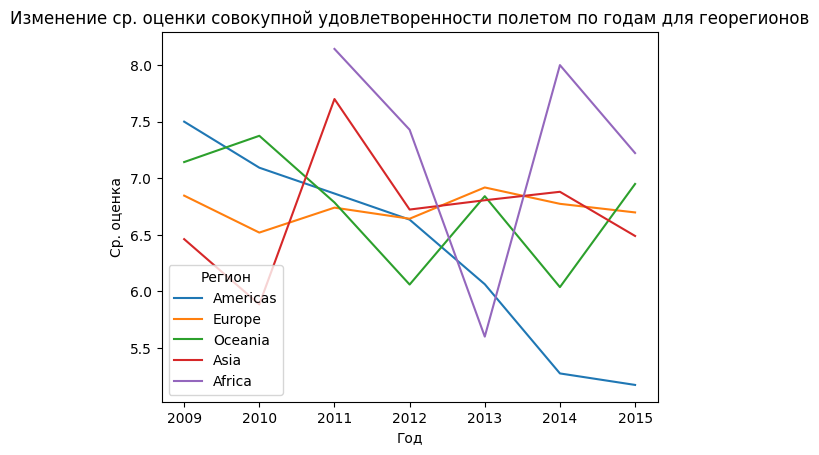

In [16]:
plot1 = sns.lineplot(data=airline_with_overall_rating,
                     x=airline_with_overall_rating.date.dt.year,
                     y="overall_rating",
                     hue="region",
                     errorbar=None
                     )

plot1.set(xlabel ="Год",
          ylabel = "Ср. оценка",
          title ='Изменение ср. оценки совокупной удовлетворенности полетом по годам для георегионов'
          )

plot1.legend(title="Регион")

Давайте посмотрим на количество оценок в 2015 году по регионам, чтобы понять, насколько ли силен дисбаланс.

Из агрегированной таблицы снизу видим, что в 2015 году пассажиры из Африки оставили всего 9 оценок, что, конечно, очень мало, но не будем исключать этот регион.

In [17]:
airline_with_overall_rating_2015 = airline_with_overall_rating[airline_with_overall_rating.date.dt.year == 2015]
airline_with_overall_rating_2015['overall_rating'].groupby(by=[airline_with_overall_rating_2015.region]).agg('count').sort_values()

,overall_rating
region,
Africa,9
Oceania,79
Asia,96
Americas,237
Europe,344


## Сравнение совокупной удовлетворенности по регионам для 2015 года

Для начала сравним распределение совокупных оценок по регионам и их медианные значения. Как видно на скрипичной диаграмме, 4 региона из 5 сильно похожи друг на друга: у них одинаковая медиана (равна 8) и схожие формы распределений с заметным левым хвостом (отрицательная ассиметрия / лево-смещенное распределение). В то же время регион "Америки" заметно отличается от остальных 4 регионов: во-первых, у него заметно ниже медианное значение (равно 5); во-вторых, распределение является бимодальным.

И прежде чем мы продолжим, стоит остановиться чуть подольше на региональном кейсе "Америк" и проверить распределения по странам, чтобы убедиться, что бимодальное распределение в регионе не является следствием объединения разных стран под одним регионом.

[Text(0.5, 0, 'Регион'),
 Text(0, 0.5, 'Оценка'),
 Text(0.5, 1.0, 'Сопоставление распределений совокупной удовлетворенности полетом по георегионам')]

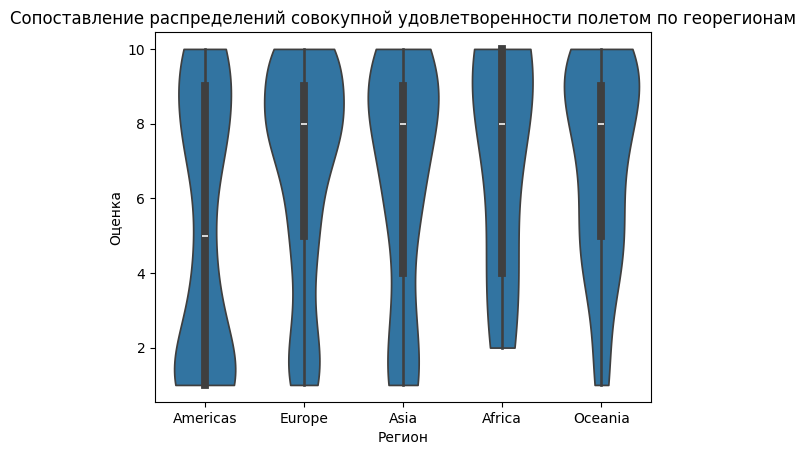

In [18]:
plot2 = sns.violinplot(x = 'region', y = 'overall_rating', data = airline_with_overall_rating_2015, cut = 0)

plot2.set(xlabel ="Регион", ylabel = "Оценка", title ='Сопоставление распределений совокупной удовлетворенности полетом по георегионам')

Построим отдельные гистограммы распределений для стран региона "Америки". Как видим, бимодальное распределение характерно для всех стран региона при условии достаточного количества наблюдений. Так что можем перейти к последнему действию для ответа на вопрос — к сопоставлению средних значений по регионам.

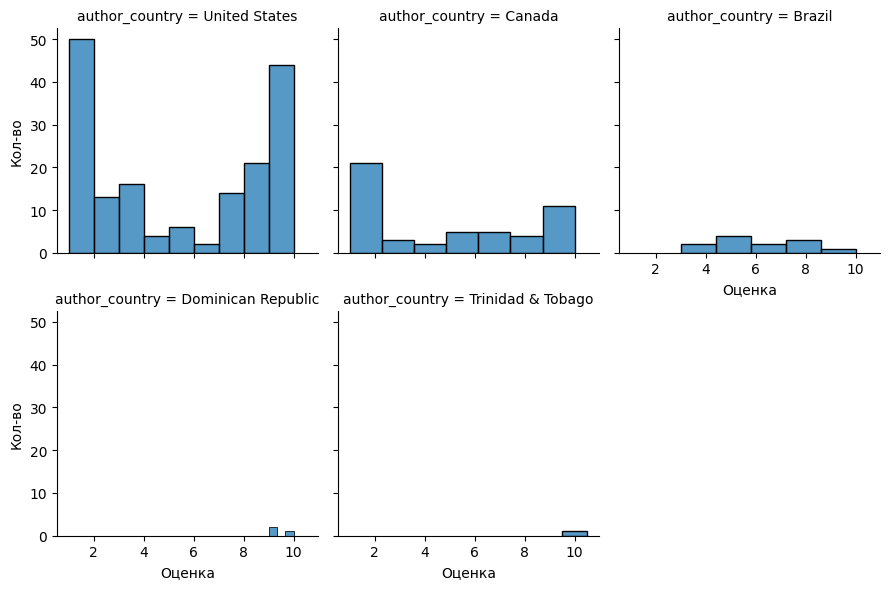

In [19]:
airline_with_overall_rating_2015_americas = airline_with_overall_rating_2015[airline_with_overall_rating_2015.region == 'Americas']
g = sns.FacetGrid(data=airline_with_overall_rating_2015_americas, col='author_country', col_wrap=3)
g.map(sns.histplot, 'overall_rating')
g.set(xlabel ="Оценка", ylabel = "Кол-во")

Ниже представлена таблица со средними значениями совокупных оценок удовлетворительности полетом по регионам. Как видим, пассажиры региона "Америки" снова оказываются самыми неудовлетворенными своим полетом относительно пассажиров из других регионов.

In [20]:
airline_with_overall_rating_2015['overall_rating'].groupby(by=[airline_with_overall_rating_2015.region]).agg('mean').sort_values()

,overall_rating
region,
Americas,5.172996
Asia,6.489583
Europe,6.697674
Oceania,6.949367
Africa,7.222222


## Заключение по вопросу 1

Пассажиры из региона "Америки" является самыми неудовлетворенными своим полетом относительно пассажиров из других регионов в 2015 году в нашем датасете, об этом свидетельствует как сопоставление медиан вместе с распределениями значений, так и сопоставление средних значений. Кроме того, дополнительная проверка во временном срезе показывает стабильный тренд на снижение среднего значения совокупной оценки удовлетворительности полетом у пассажиров из "Америк".

Исходя из этого, мы могли предложить нашему заказчику выбрать пассажиров из региона "Америки" в качестве потенциальной целевой аудитории, так как, вероятно, существующие авиакомпании не могут удовлетворить запросы этой аудитории.

Впрочем, для более надежных выводов стоит сначала сравнить регионы с помощью статического теста, чтобы понять, не имеем ли мы дело с просто случайной разницей между группами. Этому посвящен следующий пункт работы.

# Стат. тест 1: Сравнение совокупной удовлетворенности полетом по географическим регионам (для 2015 г.)

## Обоснование, выбор теста

Существует ли статистически значимая разница между географическими регионами относительно совокупной удовлетворенности полетом в 2015 году в нашем датасете? На этот вопрос важно ответить, чтобы убедиться, что обнаруженная в ходе ответа на первый вопрос разница является неслучайной.

Поскольку регион — это категориальная переменная (5 категорий), а совокупная удовлетворенность полетом — числовая (интервальная), то следует применить либо ANOVA, либо его непараметрический аналог.

Вообще говоря, при визуальной оценке распределений значений совокупной удовлетворенности полетом на скрипичной диаграмме в первом разделе мы уже видели, что ни для одного региона распределение не является нормальным: для "Америк" оно бимодальное, а в остальных регионах распределение лево-смещенное. То есть применять параметрические тесты невозможно, т.к. не соблюдается допущение о нормальности распределений.

Убедиться в ненормальности распределений можно и через формальный тест Шапиро-Уилка. Как можно видить ниже, p-значение для всех регионов, кроме Африки, ниже 0.001 (т.е. значимость на 99.9-м уровне), а для Африки оно все равно ниже 0.05 (значимость на 95-м уровне). Нулевая гипотеза о нормальности распределений отвергается. Используем непараметрический аналог, тест Краскела-Уоллиса.

In [21]:
america_2015 = airline_with_overall_rating_2015[airline_with_overall_rating_2015.region == 'Americas']
africa_2015 = airline_with_overall_rating_2015[airline_with_overall_rating_2015.region == 'Africa']
oceania_2015 = airline_with_overall_rating_2015[airline_with_overall_rating_2015.region == 'Oceania']
europe_2015 = airline_with_overall_rating_2015[airline_with_overall_rating_2015.region == 'Europe']
asia_2015 = airline_with_overall_rating_2015[airline_with_overall_rating_2015.region == 'Asia']

In [22]:
stats.shapiro(america_2015['overall_rating'])

ShapiroResult(statistic=np.float64(0.846760358359768), pvalue=np.float64(1.4120655359220092e-14))

In [23]:
stats.shapiro(africa_2015['overall_rating'])

ShapiroResult(statistic=np.float64(0.8342066371511123), pvalue=np.float64(0.049771058233340784))

In [24]:
stats.shapiro(oceania_2015['overall_rating'])

ShapiroResult(statistic=np.float64(0.9022211591998696), pvalue=np.float64(1.6921780256685366e-05))

In [25]:
stats.shapiro(europe_2015['overall_rating'])

ShapiroResult(statistic=np.float64(0.8795761864777222), pvalue=np.float64(9.039838329872897e-16))

In [26]:
stats.shapiro(asia_2015['overall_rating'])

ShapiroResult(statistic=np.float64(0.8661283615910615), pvalue=np.float64(7.905564796917333e-08))

## Тест Краскела-Уоллиса

Статистические гипотезы H0 и H1 для теста Краскела-Уоллиса можно задавать в двух видах: либо на разницу медиан (строгая формулировка), либо на стохастическое доминирование одного распределения над другим (нестрогая формулировка). Строгая формулировка требует, чтобы формы распределений всех групп были похожими, что, как мы уже увидели на скрипичной диаграмме ранее, не соответствует нашим данным. Поэтому задавать гипотезы будем на стохастическое доминирование (впрочем, нас с практической точки зрения все равно интересует подтверждение наличия разницы между группами, а как это сформулировано статистически — вопрос вторичный).

* H0: Стохастическое доминирование распределений отсутствует.
* H1: Хотя бы одного распределение стохастически доминирует над другим.

Как видим ниже, тест имеет p-значение ниже 0.001, что позволяет на 99.9-м уровне доверия отвергнуть нулевую гипотезу в пользу альтернативной. Таким образом, существует неслучайная разница между регионами. Однако сам по себе тест Краскела-Уоллиса не может нам сказать, между какими именно регионами наблюдается неслучайная разница (может, в случае с "Америками" разницы с другими регионами и нет, а результат дает сравнение других регионов?). Применим непараметрический пост-хок тест Данна, чтобы понять разницу между конкретными регионами.

In [27]:
stats.kruskal(america_2015['overall_rating'], africa_2015['overall_rating'], oceania_2015['overall_rating'], europe_2015['overall_rating'], asia_2015['overall_rating'])

KruskalResult(statistic=np.float64(30.286286886310783), pvalue=np.float64(4.279612720886095e-06))

## Пост-хок тест Данна

Воспользуемся апостериорным критерием Данна, реализованным в библиотеке "scikit_posthocs" (установлена в Collab дополнительно в начале работы). Т.к. мы проводим множественные сравнения, используем поправку Холма-Бонферрони.

Как видно из таблицы ниже, регион "Америки" действительно значимо отличается от практически всех регионов, за исключением "Африки" (но там всего 9 наблюдений), причем это единственный регион, который как-то отличается от других:

* значимая разница между "Америками" и "Азией" на 95-м уровне доверия (p < 0.05),
* значимая разница между "Америками" и "Океанией" на 99-м уровне доверия (p < 0.01),
* значимая разница между "Америками" и "Европой" на 99.9-м уровне доверия (p < 0.001).

In [28]:
sp.posthoc_dunn(a = airline_with_overall_rating_2015,
                val_col = 'overall_rating',
                group_col = 'region',
                p_adjust='holm')

,Africa,Americas,Asia,Europe,Oceania
Africa,1.000000,0.358107,1.000000,1.000000,1.000000
Americas,0.358107,1.000000,0.021124,0.000009,0.001376
Asia,1.000000,0.021124,1.000000,1.000000,1.000000
Europe,1.000000,0.000009,1.000000,1.000000,1.000000
Oceania,1.000000,0.001376,1.000000,1.000000,1.000000


## Заключение по стат. тесту 1

Результаты теста Краскела-Уоллиса подтвердили наличие разницы между регионами в распределениях совокупной удовлетворенности полетом. Пост-хок тест Данна подтвердил, что неслучайная разница существует между "Америками" и другими регионами (кроме "Африки", где число наблюдений слишком маленькое).

Мы можем подтвердить вывод о разнице "Америк" с другими регионами, полученный в ходе визуального анализа при ответе на вопрос 1. Пассажиры региона "Америки" действительно имеют наименьшую совокупную удовлетворенность полетом и эта разница неслучайна.

С практической точки зрения мы действительно можем порекомендовать нашему заказчику обратить внимание на пассажиров этого региона и взять их за целевую аудиторию.

# Вопрос 2: Как различается совокупная удовлетворенность полетом у пассажиров из региона "Америки" в 2015 году в зависимости от класса пассажира?

## Обоснование

Мы уже определили, что пассажиры из региона "Америки" могли бы стать хорошей целевой аудиторией для заказчика. Но попробуем немного сузить целевую аудиторию. У нас в датасете не так много контекстуальной информации, но есть полезная колонка с классом пассажира. А что если пассажиры по-разному удовлетворены полетом в зависимости от класса полета? Тогда заказчик мог бы сфокусироваться только на одном классе с наименьшими показателями.

## Объединим классы для удобства

Для начала посмотрим, какими классами летали пассажиры из региона "Америки" в 2015 году и в каком количестве. Как видим ниже, летают чаще всего "Экономом", а реже всего "Премиум-экономом". Впрочем, "Первым классом" тоже летали довольно редко. Кажется, что классы, которыми летают редко, будет тяжело сравнивать с более часто используемыми классами. Так что есть смысл объединить категории: "Эконом-класс" объединить с "Премиум-экономом", а "Бизнес-класс" объединить с "Первым классом". Учитывая порядковый характер переменной и сходство классов по принципу привилегированности пассажира, такое объединение будет довольно органичным.

In [29]:
america_2015['overall_rating'].groupby(by=[america_2015.cabin_flown]).agg('count').sort_values()

,overall_rating
cabin_flown,
Premium Economy,12
First Class,16
Business Class,47
Economy,148


Пишем простую функцию для удобства и создаем новую колонку с двумя категориями: "Эконом (включая Премиум)" и "Бизнес и первый класс". Иначе говоря, мы делим пассажиров на условно "непривилегированных" и "привилегированных".

In [31]:
def cabin_simplifier(cabin_original):
  if cabin_original == "Economy" or cabin_original == "Premium Economy":
    return "Economy (incl. Premium)"
  elif cabin_original == "First Class" or cabin_original == "Business Class":
    return "Business & First"
  else:
    return np.nan

america_2015.loc[:, 'cabin_simple'] = america_2015.loc[:, 'cabin_flown'].apply(cabin_simplifier)

Теперь мы имеем дело с двумя категориями с адекватным количеством наблюдений для сравнения.

In [32]:
america_2015['overall_rating'].groupby(by=[america_2015.cabin_simple]).agg('count').sort_values()

,overall_rating
cabin_simple,
Business & First,63
Economy (incl. Premium),160


## Непосредственно сравнение

Для начала построим скрипичную диаграмму для сравнения распределений совокупной удовлетворенности полетом. Как видим ниже, во-первых, есть разница в формах распределений: распределение оценок у пассажиров "Эконома" бимодальное, тогда как распределение оценок у пассажиров "Бизнес + первый класс" лево-смещенное. Во-вторых, видна резкая разница в медианных значениях: у пассажиров "Эконома" медиана равна 3, а у пассажиров "Бизнес + первый класс" она равна 8.

[Text(0.5, 0, 'Класс полета'),
 Text(0, 0.5, 'Оценка'),
 Text(0.5, 1.0, 'Сопоставление распределений совокупной удовлетворенности полетом по классам полета')]

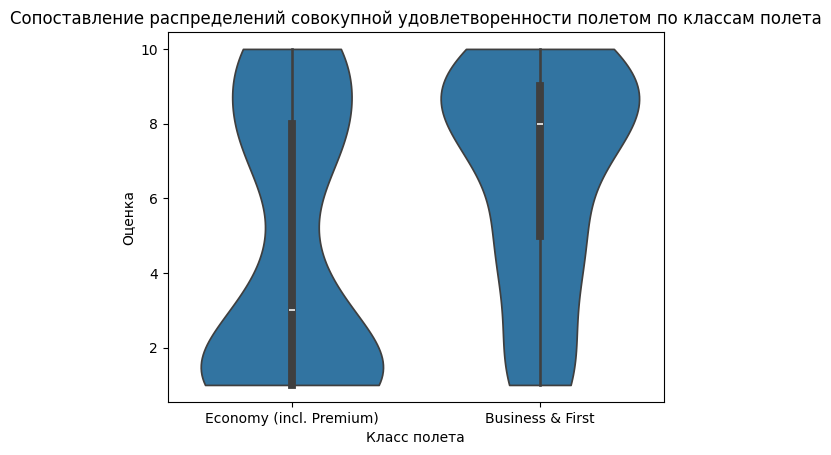

In [33]:
plot3 = sns.violinplot(x = 'cabin_simple', y = 'overall_rating', data = america_2015, cut = 0)
plot3.set(xlabel ="Класс полета", ylabel = "Оценка", title ='Сопоставление распределений совокупной удовлетворенности полетом по классам полета')

Также, как видим ниже, наблюдается разница в средних значениях, где "Эконом" снова имеет более низкое значение по сравнению с "Бизнес + первый класс".

In [34]:
america_2015['overall_rating'].groupby(by=[america_2015.cabin_simple]).agg('mean').sort_values()

,overall_rating
cabin_simple,
Economy (incl. Premium),4.743750
Business & First,6.619048


## Заключение по вопросу 2

Среди пассажиров из региона "Америки" в 2015 году мы видим различия в совокупной удовлетворительности полетом в зависимости от класса полета: медианное и среднее значение у пассажиров "Эконома" ниже, чем у пассажиров из группы "Бизнес + первый класс".

Исходя из этого, мы могли предложить нашему заказчику сузить целевую аудиторию до пассажиров "Эконома" (непривилегированных пассажиров) из региона "Америки", так как, вероятно, существующие авиакомпании не могут удовлетворить запросы непосредственно этой аудитории.

Впрочем, для более надежных выводов стоит сначала сравнить две категории с помощью статического теста, чтобы понять, не имеем ли мы дело с просто случайной разницей. Этому посвящен следующий пункт работы.

# Стат. тест 2: Сравнение совокупной удовлетворенности полетом по объединенному классу полета (для 2015 г., для пассажиров из региона "Америки")

## Обоснование, выбор теста

Существует ли статистически значимая разница между двумя объединенными классами полета относительно совокупной удовлетворенности полетом в 2015 году среди пассажиров региона "Америки"? На этот вопрос важно ответить, чтобы убедиться, что обнаруженная в ходе ответа на второй вопрос разница является неслучайной.

Поскольку класс полета после наших преобразований — это по сути бинарная переменная, а совокупная удовлетворенность полетом — числовая (интервальная), то следует применить либо t-тест, либо его непараметрический аналог.

При визуальной оценке распределений значений совокупной удовлетворенности полетом на скрипичной диаграмме мы уже видели, что ни для одного из двух классов полета распределение не является нормальным: для "Эконома" оно бимодальное, а для "Бизнес + первый класс" распределение лево-смещенное. То есть применять параметрические тесты невозможно, т.к. не соблюдается допущение о нормальности распределений.

Убедиться в ненормальности распределений можно и через формальный тест Шапиро-Уилка. Как можно видить ниже, p-значение для обоих классов ниже 0.001 (т.е. значимость на 99.9-м уровне). Нулевая гипотеза о нормальности распределений отвергается. Используем непараметрический аналог, тест Манна-Уитни.

In [35]:
priviliged_america_2015 = america_2015[america_2015.cabin_simple == 'Business & First']
unpriviliged_america_2015 = america_2015[america_2015.cabin_simple == 'Economy (incl. Premium)']

In [36]:
stats.shapiro(priviliged_america_2015['overall_rating'])

ShapiroResult(statistic=np.float64(0.8772235521466424), pvalue=np.float64(1.4091596350301961e-05))

In [37]:
stats.shapiro(unpriviliged_america_2015['overall_rating'])

ShapiroResult(statistic=np.float64(0.8256786464175745), pvalue=np.float64(1.5578121086092875e-12))

## Тест Манна-Уитни

Зададим гипотезы в простом виде — как сравнение распределений.

* H0: Разница в распределениях отсутствует.
* H1: Существует разница в распределениях.

Как видим ниже, p-значение меньше 0.001: это означает, что на 99.9-м уровне доверия мы можем отвергнуть нулевую гипотезу в пользу альтернативной. Иначе говоря, разница в распределениях существует.

In [38]:
stats.mannwhitneyu(priviliged_america_2015['overall_rating'], unpriviliged_america_2015['overall_rating'])

MannwhitneyuResult(statistic=np.float64(6537.0), pvalue=np.float64(0.00047701250681504937))

## Заключение по стат. тесту 2

Результаты теста Манна-Уитни подтвердили наличие разницы между пассажирами "Эконома" и пассажирами "Бизнес + первый класс" в распределениях совокупной удовлетворенности полетом в 2015 г. (для региона "Америки").

Мы можем подтвердить вывод о разнице двух объединенных классов, полученный в ходе визуального анализа при ответе на вопрос 2. Пассажиры из "Эконома" действительно менее удовлетворены полетами, и эта разница неслучайна (для пассажиров региона "Америки", 2015 г.).

С практической точки зрения мы можем порекомендовать нашему заказчику сузить целевую аудиторию: вместо всех пассажиров региона "Америки" мы предлагаем ему взять пассажиров эконом-класса (включая премиум-эконом) в качестве своей целевой аудитории, так как они действительно сильно неудовлетворены полетами в отличие от пассажиров категории "Бизнес + первый класс".

# Вопрос 3: У кого из потенциальных конкурентов наихудшие сидения в салонах?

Итак, мы определили довольно узкую целевую аудиторию для нашего заказчика — пассажиры эконом-класса (включая премиум-эконом) из региона "Америки". Но мы пока что никак не рассмотрели потенциальных конкурентов и их слабые стороны (за счет чего заказчик смог бы опередить их?). Давайте займемся этим. Сначала определим, какие компании могли бы быть конкурентами нашему заказчику, учитывая уже определенную нами целевую аудиторию, а затем попытаемся посмотреть на удовлетворенность пассажиров наших конкурентов сидениями в салонах и определить самые слабые компании в этом аспекте удовлетворенности полетом (возможно, именно с этими компаниями стоило бы конкуририровать нашему заказчику, чтобы преуспеть).

## Определение ключевых конкурентов

Очевидно, что страна автора отзыва или его регион необязательно означают, что авиакомпания, на рейс которой написан отзыв, обслуживает преимущественно пассажиров из этой страны или этого региона. Например, если единичный американец прилетит в Россию и воспользуется внутренним рейсом "Аэрофлота", "Аэрофлот" все равно не будет считать американцев своей целевой аудиторией. Однако если пассажиры эконом-класса из региона "Америки" пользуются какими-то компаниями в датасате чаще других (чаще пишут на них отзывы), то это будут, вероятно, компании, нацеленные на эту аудиторию или хотя бы часто обслуживающие эту аудиторию.

Для начала посмотрим, на какое количество компаний всего было написано отзывов нашей целевой аудиторией. Видим, что на 59 авиакомпаний, это очень много. Среди них явно есть не интересующие нас авиакомпании. Решим эту проблему.


In [39]:
unpriviliged_america_2015[unpriviliged_america_2015.airline_name.notnull()].airline_name.unique().size

59

Определим, на рейсы каких компаний чаще всего пишет отзывы наша целевая аудитория в 2015 году: посчитаем количество отзывов на компанию от пассажиров эконом-класса из региона "Америки" в 2015 году, а также построим рейтинг компаний по кол-ву отзывов. Для удобства также посчитаем кумулятивный %, чтобы понимать суммарную долю этих авиакомпаний из верхушки построенного рейтинга.

Как видим ниже, на первые 10 компаний в списке по количеству отзывов от целевой аудитории в 2015 году приходится 60.26% от количества всех отзывов, написанных нашей целевой аудиторией в 2015 году. В целом, кажется, что можно остановиться на этой десятке и признать эти 10 компаний в качестве потенциальных конкурентов нашему заказчику, т.к. на них приходится больше половины всех отзывов от нашей целевой аудитории. Кроме того, если мы "загуглим" эти компании, то увидим, что они либо американские (США), либо канадские, причем зачастую по типу лоукостеров, то есть действительно нацелены на пассажиров эконома.

P.S. Единственное исключение в виде "Британских авиалиний", изначально попадающих в топ-10, исключено из списка, т.к. будем фокусироваться на компаниях из того же георегиона, что и пассажиры из целевой аудитории.


In [40]:
# топ-10 по кол-ву отзывов
n_reviews_per_company = unpriviliged_america_2015['airline_name'].groupby(by=[unpriviliged_america_2015.airline_name]).agg('count').sort_values(ascending = False)
n_reviews_per_company = n_reviews_per_company.drop(labels=['british-airways'])
n_reviews_per_company.head(10)

,airline_name
airline_name,
air-canada-rouge,15
allegiant-air,12
united-airlines,12
air-canada,11
american-airlines,10
spirit-airlines,9
frontier-airlines,9
sunwing-airlines,8
southwest-airlines,4


In [41]:
# кумулятивный процент
cum_table = n_reviews_per_company.cumsum() / n_reviews_per_company.sum()
cum_table.head(10)

,airline_name
airline_name,
air-canada-rouge,0.096154
allegiant-air,0.173077
united-airlines,0.250000
air-canada,0.320513
american-airlines,0.384615
spirit-airlines,0.442308
frontier-airlines,0.500000
sunwing-airlines,0.551282
southwest-airlines,0.576923


## Попытка определить отстающих конкурентов, используя таблицу "Seat"

В используемом датасете есть отдельная таблица, в которой собраны подробные отзывы на сидения в салонах самолетов разных авиакомпаний. Полагаем, что написание отдельного отзыва с рассмотрением разных аспектов удобности сидений (пространство для ног, ширина кресла и др.) является более рефлексивным, нежели просто оценка удобства кресла в общем отзыве на полет в таблице "Airline". То есть можно ожидать, что совокупная оценка кресел из таблицы "Seat" будет более полезной, нежели оценка из таблицы "Airline". Попробуем воспользоваться таблицей "Seat".

Загрузим таблицу и посмотрим на первые 3 строки для лучшего понимания данных.

In [42]:
seat = pd.read_csv('/content/drive/MyDrive/Python_Course_Sociology/Project_1/seat.csv')
seat.head(3)

,airline_name,link,title,author,author_country,date,content,aircraft,seat_layout,date_flown,...,type_traveller,overall_rating,seat_legroom_rating,seat_recline_rating,seat_width_rating,aisle_space_rating,viewing_tv_rating,power_supply_rating,seat_storage_rating,recommended
0,air-canada,/seat-reviews/air-canada,Air Canada customer review,Tyler Thomson,Canada,2014-01-03,The XM interior that Air Canada introduced a f...,AIRBUS A320,3X3,NaN,...,NaN,9,5,4,5,4,5.0,NaN,NaN,1
1,air-canada,/seat-reviews/air-canada,Air Canada customer review,J Wong,New Zealand,2011-09-19,Good legroom no in flight entertainment compon...,B777-200LR,3x3x3,NaN,...,NaN,8,4,4,5,5,5.0,NaN,NaN,1
2,air-france,/seat-reviews/air-france,Air France customer review,K Roberts,United States,2014-07-24,The seat did not actually recline it sort of s...,AIRBUS A380,2x3x2,NaN,...,NaN,3,4,1,3,3,3.0,NaN,NaN,0


Сделаем базовую проверку на дубликаты. К сожалению, как минимум один какой-то текст отзыва продублирован в датафрейме.

In [43]:
seat['content'].duplicated().any()

np.True_

Посмотрим, что это за отзывы-дубликаты. Как видим, вообще говоря этот отзыв нас не интересует, так как относится к не интересующей нас авиакомпании из Австралии.

In [44]:
seat[seat.content.duplicated()]

,airline_name,link,title,author,author_country,date,content,aircraft,seat_layout,date_flown,...,type_traveller,overall_rating,seat_legroom_rating,seat_recline_rating,seat_width_rating,aisle_space_rating,viewing_tv_rating,power_supply_rating,seat_storage_rating,recommended
48,virgin-australia,/seat-reviews/virgin-australia,Virgin Australia customer review,B Johnson,United States,2013-01-18,LAX-BNE. Premium Economy seats were very comfo...,BOEING 737-800,3x3,NaN,...,NaN,5,2,2,3,3,0.0,NaN,NaN,0


Давайте отфильтруем нужные нам строки в таблице "Seat" (то есть чтобы авиакомпания была из определенного нами списка 10 конкурентов). Это можно сделать по-разному, но давайте пойдем более сложным.

Переведем Pandas-серию из предыдущего подпункта про определение конкурентов в датафрейм и воспользуемся им, чтобы через inner-джойн с таблицей "Seat" по ключу "airline_name" получить желаемую таблицу, в которой останутся только отзывы на сидения у 10 компаний-конкурентов.

In [45]:
cum_table_top10_df = cum_table.head(10).to_frame()
cum_table_top10_df.rename(columns={"airline_name": "cum_perc"}, inplace=True)
cum_table_top10_df = cum_table_top10_df.reset_index()
cum_table_top10_df

seats_of_competitors = pd.merge(
    left=cum_table_top10_df,
    right=seat,
    how='inner',
    left_on=['airline_name'],
    right_on=['airline_name'],
)

Джойн прошел успешно, в датафрейме только нужные компании.

Но, как мы видим, из 10 определенных нами компаний-конкурентов только для 6 был написан хотя бы один отзыв на сидения, это уже довольно плохо.

In [46]:
seats_of_competitors.airline_name.unique()

array(['air-canada-rouge', 'allegiant-air', 'united-airlines',
       'air-canada', 'american-airlines', 'spirit-airlines'], dtype=object)

Впрочем, если мы посмотрим на количество отзывов на сиденья у интересующих нас компаний, то все еще намного хуже, так как это количество очень маленькое, у трех компаний вообще только по одному отзыву. И это мы еще не проверяли даже дату у этих отзывов!

Какой промежуточный вывод мы можем сделать? К сожалению, таблица "Seat" никак не может помочь нам с определением отстающих в качестве сидений конкурентов, поскольку объем выборки слишком маленький. Возможно, что пассажиры не любят писать отдельные отзывы на сиденья или же не любят делать это на сайте, с которого выкачали данные. Также возможны какие-либо технические проблемы при выгрузке данных. Техническому исполнителю, который предоставил заказчику таблицу, следует проверить таблицу на полноту данных. В случае же, если малое количество отзывов в таблице не связано с техническими проблемами, стоит найти другой источник данных.

В текущем отчете попробуем воспользоваться основной таблицей "Airlines", а именно колонкой "seat_comfort_rating".

In [47]:
seats_of_competitors['overall_rating'].groupby(by=[seats_of_competitors.airline_name]).agg('count').sort_values(ascending = False)

,overall_rating
airline_name,
american-airlines,5
united-airlines,4
air-canada,3
air-canada-rouge,1
allegiant-air,1
spirit-airlines,1


## Попытка определить отстающих конкурентов, используя таблицу "Airline"

Создадим отдельный датафрейм с отзывами на полеты, написанные нашей целевой аудиторией* на определенные нами 10 компаний-конкурентов в 2015 году.

После чего создадим датафрейм, в котором отфильтруем те отзывы, в которых была оставлена оценка комфортности кресел в полете.

\* Вообще говоря, мы могли бы брать отзывы с оценками кресел у компаний-конкурентов, написанные не только нашей целевой аудиторией, чтобы повысить объем выборок, но более широкие выборки снизят репрезентативность (в нестрогом смысле) результатов. Поскольку наш заказчик будет нацелен на целевую аудиторию, ему будет интересен именно ее опыт, а потому расширение выборок считаем неоправданным.

In [48]:
competitors_airline_2015 = pd.merge(
                                    left=cum_table_top10_df,
                                    right=unpriviliged_america_2015,
                                    how='inner',
                                    left_on=['airline_name'],
                                    right_on=['airline_name'],
                                    )

competitors_airline_2015_with_seat_rating = competitors_airline_2015[competitors_airline_2015['seat_comfort_rating'].notnull()]

Как видим, с количеством отзывов, где есть оценка комфортности кресел, в таблице "Airlines" все лучше, чем в таблице "Seat". Конечно, это все равно слишком малое количество, но предварительный анализ для выработки гипотезы к последующей проверке мы провести можем.

In [49]:
competitors_airline_2015_with_seat_rating['seat_comfort_rating'].groupby(by=[competitors_airline_2015_with_seat_rating.airline_name]).agg('count').sort_values(ascending = False)

,seat_comfort_rating
airline_name,
air-canada-rouge,15
allegiant-air,12
united-airlines,12
air-canada,11
american-airlines,10
frontier-airlines,9
spirit-airlines,9
sunwing-airlines,8
delta-air-lines,4


Ниже построена довольно большая скрипичная диаграмма, в которой авиакомпании-конкуренты упорядочены от большего значения медианы к меньшему. Как видим, 4 крайние правые авиакомпании имеют наименьшее медианное значение (медиана равна 1).

Иначе говоря, по медианному значению оценки комфортности кресел в полете авиакомпании "Sunwing Airlines", "Spirit Airlines", "American Airlines" и "Air Canada Rouge" являются хорошими кандидатами на признание самыми слабыми по комфортности кресел среди 10 выявленных нами конкурентов.

[Text(0.5, 0, 'Авиакомпания'),
 Text(0, 0.5, 'Оценка'),
 Text(0.5, 1.0, 'Сопоставление распределений оценок комфортности кресел по авиакомпаниям-конкурентам')]

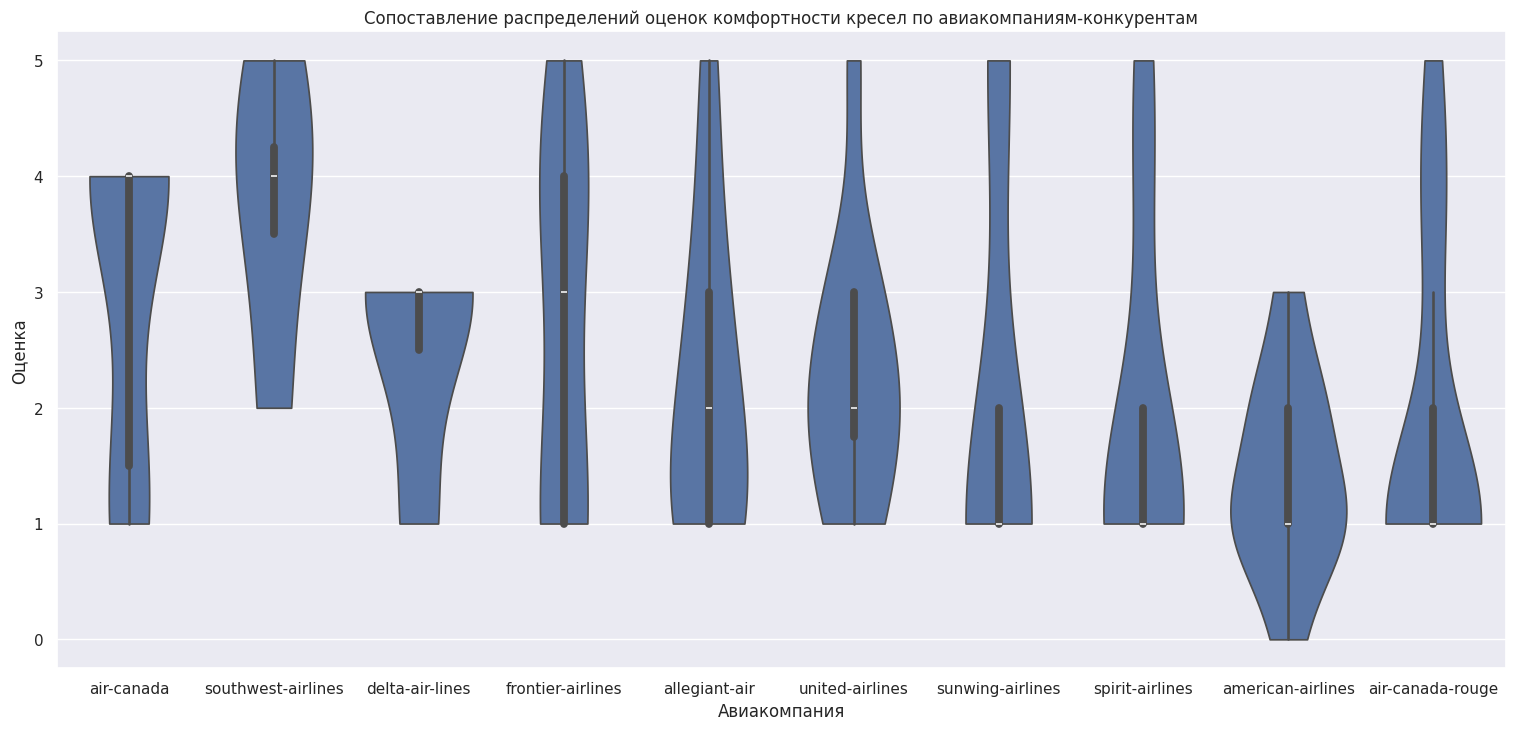

In [50]:
order_by_median = competitors_airline_2015_with_seat_rating.groupby(by=['airline_name'])['seat_comfort_rating'].median().sort_values().iloc[::-1].index

sns.set_theme(rc={'figure.figsize':(18.7,8.27)})

plot4 = sns.violinplot(x = 'airline_name', y = 'seat_comfort_rating', data = competitors_airline_2015_with_seat_rating, cut = 0, order = order_by_median)
plot4.set(xlabel ="Авиакомпания", ylabel = "Оценка", title ='Сопоставление распределений оценок комфортности кресел по авиакомпаниям-конкурентам')

Если мы составим рейтинг компаний-конкурентов по среднему значению оценки комфортности кресел, то все те же 4 компании находятся на последних местах, хотя их позиции на этих последних местах незначительно поменялись между собой. Опять же, это свидетельство в пользу того, что именно эти компании являются хорошими кандидатами на признание самыми слабыми по комфортности кресел среди 10 выявленных нами конкурентов.

In [51]:
competitors_airline_2015_with_seat_rating['seat_comfort_rating'].groupby(by=[competitors_airline_2015_with_seat_rating.airline_name]).agg('mean').sort_values(ascending = False)

,seat_comfort_rating
airline_name,
southwest-airlines,3.750000
air-canada,3.000000
frontier-airlines,2.666667
delta-air-lines,2.500000
united-airlines,2.250000
allegiant-air,2.166667
sunwing-airlines,2.000000
spirit-airlines,1.888889
air-canada-rouge,1.800000


## Заключение по вопросу 3

В данном разделе отчета мы сначала определили 10 потенциальных конкурентов нашему заказчику, ориентируясь на то, на рейсы каких авиакомпаний чаще всего пишут представители определенной нами целевой аудитории. Чтобы понять, у кого из этих 10 конкурентов самые худшие сидения в салонах (с кем нашему заказчику можно было бы эффективнее конкурировать в борьбе за целевую аудиторию), мы попытались сначала воспользоваться специализированной таблицей "Seat", однако из-за критической неполноты данных мы вынуждены были использовать таблицу "Airline".

Мы определили, что наихудшие оценки комфортности кресел, если строить рейтинг как по медиане, так и по среднему значению, наблюдаются у компаний-конкурентов  "Sunwing Airlines", "Spirit Airlines", "American Airlines" и "Air Canada Rouge". Однако мы не можем надежно утверждать, что эта разница неслучайная без применения стат. тестов; более того, размер выборок крайне маленький.

Мы могли бы порекомендовать заказчику:

1. Убедиться в корректности процедуры сбора данных для таблицы "Seat" по причине неполноты данных в таблице. Если на сайте, с которого собирались отзывы, их действительно так мало, то стоит найти альтернативный источник подробных отзывов на кресла авиакомпаний.

2. Стоит заказать сбор дополнительных данных о компаниях "Sunwing Airlines", "Spirit Airlines", "American Airlines" и "Air Canada Rouge" как потенциальных конкурентах. Крайне вероятно, что требуется отдельное маркетинговое исследование, чтобы понять их уязвимости в плане сидений в салонах.

# Выводы

Как мы помним, задание от заказчика состояло в том, чтобы найти ему определенную нишу в бизнесе пассажирских авиаперевозок и предложить ему дальнейшие действия.

Во-первых, мы определили целевую аудиторию для нашего заказчика — это пассажиры эконом-класса (включая эконом-премиум) из географического макрорегиона "Америки". Эта целевая аудитория является наименее удовлетворенной своими полетами, а потому заказчик мог бы войти на рынок с идеей повысить удовлетворенность полетами этой целевой аудитории.

Во-вторых, мы определили, какие 10 авиакомпаний являются ключевыми для нашей целевой аудитории (на них представители целевой аудтории чаще всего пишут отзывы) — это потенциальные конкуренты для нашего заказчика. Мы также смогли определить, что из этих 10 компаний у 4-х наихудшие показатели удовлетворенности комфортом кресел среди представителей целевой аудитории. Это "Sunwing Airlines", "Spirit Airlines", "American Airlines" и "Air Canada Rouge". Именно с этими авиакомпаниями, возможно, заказчику стоит соревноваться в первую очередь. Однако мы не можем быть уверены, что разница в авиакомпаниях по комфорту кресел является неслучайной из-за малых размеров выборок.

Мы предлагаем заказчику:

1. Остановиться на пассажирах эконом-класса из георегиона "Америки" в качестве целевой аудитории.

2. В идеале заказать сбор дополнительной информации о всех 10 выделенных нами потенциальных компаниях-конкурентах, поскольку в предоставленном датасете мало контекстуальной информации о них. Более того, у нас практически отсутствует детализированная информации о креслах в салонах их самолетов и мы не знаем, по какой именно причине у одних авиакомпаний оценки комфортности кресел меньше, чем у других (ответ на этот вопрос могла бы дать предоставленная таблица "Seat", но в ней критическая неполнота данных).

3. Заказать отдельное исследование на определение совокупности факторов, определяющих (не)удовлетворенность полетом представителями целевой аудитории, так как у нас нет гарантии того, что комфорт кресел является сильным фактором. То, что существует бизнес-ниша, в которой есть авиакомпании с креслами, которыми недовольны представители целевой аудитории, не означает, что вхождение в эту нишу с улучшением кресел обеспечит довольных клиентов, т.к. следует принимать во внимание совокупность факторов.